In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
## 2.a
import boto3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, LassoCV
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import recall_score

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'danhtran358-data-445-bucket'
bucket = s3.Bucket(bucket_name)

## Get file content
telecom_train_stream = bucket.Object('churn-bigml-80.csv').get().get('Body')
telecom_test_stream = bucket.Object('churn-bigml-20.csv').get().get('Body')

## Reading the csv file
telecom_train = pd.read_csv(telecom_train_stream)
telecom_test = pd.read_csv(telecom_test_stream)

telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [4]:
## 2.b
## Numeralize categorical variable Churn
telecom_train['Churn'] = np.where(telecom_train['Churn'] == False, 0, 1)
telecom_test['Churn'] = np.where(telecom_test['Churn'] == False, 0, 1)

## Numeralize categorical variable International_plan
telecom_train['International_plan'] = np.where(telecom_train['International_plan'] == 'No', 0, 1)
telecom_test['International_plan'] = np.where(telecom_test['International_plan'] == 'No', 0, 1)

## Numeralize categorical variable Voice_mail_plan
telecom_train['Voice_mail_plan'] = np.where(telecom_train['Voice_mail_plan'] == 'No', 0, 1)
telecom_test['Voice_mail_plan'] = np.where(telecom_test['Voice_mail_plan'] == 'No', 0, 1)

## Create total_charge variable
telecom_train['total_charge'] = np.sum(telecom_train[['Total_day_charge', 'Total_eve_charge', 'Total_night_charge', 'Total_intl_charge']], axis = 1)
telecom_test['total_charge'] = np.sum(telecom_test[['Total_day_charge', 'Total_eve_charge', 'Total_night_charge', 'Total_intl_charge']], axis = 1)

In [5]:
## 2.c
## Filter the input variables
telecom_train = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls', 'Churn']]
telecom_test = telecom_test[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls', 'Churn']]

In [6]:
## 2.d
## Define input and target variables
X = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y = telecom_train['Churn']

## scaler to use throught out the code
scaler = MinMaxScaler()

## list to store coefficient of LASSO models
lasso_coef = list()

for i in range(1000):
    ## Split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

    ## Scale input variables to range 0-1
    X_train = scaler.fit_transform(X_train)

    ## Find optimal lambda use LASSO cross validation
    lasso_cv = LassoCV(normalize = True, cv = 5).fit(X_train, Y_train)
    lasso_optimal_lambda = lasso_cv.alpha_

    ## Build LASSO model
    lasso_md = Lasso(normalize = True, alpha = lasso_optimal_lambda).fit(X_train, Y_train)
    lasso_coef.append(lasso_md.coef_)
    
## get the count of 0 in each column
lasso_coef_df = pd.DataFrame(lasso_coef)
print((lasso_coef_df == 0).sum())

0    266
1      0
2      0
3      0
4      0
dtype: int64


In [7]:
## Dropping column Account_length for having more than 200 times coefficient equals to 0
telecom_train = telecom_train.drop(columns = ['Account_length'], axis = 1)
telecom_test = telecom_test.drop(columns = ['Account_length'], axis = 1)
telecom_train.head()

,International_plan,Voice_mail_plan,total_charge,Customer_service_calls,Churn
0,0,1,75.56,1,0
1,0,1,59.24,1,0
2,0,0,62.29,0,0
3,1,0,66.80,2,0
4,1,0,52.09,3,0


In [8]:
## 2.e
## Defind model fitting as functions

## function to get recall from multilayer perceptron 1
def get_mlp1_recall(X_train, X_test, Y_train, Y_test):
    ## Multilayer perceptron 1
    ## Define mlp structure
    mlp_md1 = tf.keras.models.Sequential([
          tf.keras.layers.Dense(5, input_dim = 4, activation = 'tanh'),
          tf.keras.layers.Dense(2, activation = 'softmax')
    ])

    ## Compile and fit model to data
    mlp_md1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    mlp_md1.fit(X_train, tf.keras.utils.to_categorical(Y_train), epochs = 100, batch_size = 100, verbose = 0)

    ## Predict probability 
    predict_md1 = mlp_md1.predict(X_test)[:,1]

    ## Classify labels and calculate recall
    predict_md1 = np.where(predict_md1 < 0.1, 0, 1)
    return recall_score(Y_test, predict_md1)

## function to get recall from multilayer perceptron 2
def get_mlp2_recall(X_train, X_test, Y_train, Y_test):
    ## Multilayer perceptron 2
    ## Define mlp structure
    mlp_md2 = tf.keras.models.Sequential([
          tf.keras.layers.Dense(5, input_dim = 4, activation = 'relu'),
          tf.keras.layers.Dense(2, activation = 'softmax')
    ])

    ## Compile and fit model to data
    mlp_md2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    mlp_md2.fit(X_train, tf.keras.utils.to_categorical(Y_train), epochs = 100, batch_size = 100, verbose = 0)

    ## Predict probability 
    predict_md2 = mlp_md2.predict(X_test)[:,1]

    ## Classify labels and calculate recall
    predict_md2 = np.where(predict_md2 < 0.1, 0, 1)
    return recall_score(Y_test, predict_md2)

## function to get recall from support vector machine model 1
def get_svm1_recall(X_train, X_test, Y_train, Y_test):
    ## Support vector machine model 1
    ## Building the svm with kernel = 'rbf'
    svm_md3 = SVC(kernel = 'rbf', probability = True).fit(X_train, Y_train)

    ## Predict probability 
    predict_md3 = svm_md3.predict_proba(X_test)[:,1]

    ## Classify labels and calculate recall
    predict_md3 = np.where(predict_md3 < 0.1, 0, 1)
    return recall_score(Y_test, predict_md3)

## function to get recall from support vector machine model 2
def get_svm2_recall(X_train, X_test, Y_train, Y_test):
    ## Support vector machine model 2
    ## Building the svm with kernel = 'rbf'
    svm_md4 = SVC(kernel = 'poly', probability = True).fit(X_train, Y_train)

    ## Predict probability 
    predict_md4 = svm_md4.predict_proba(X_test)[:,1]

    ## Classify labels and calculate recall
    predict_md4 = np.where(predict_md4 < 0.1, 0, 1)
    return recall_score(Y_test, predict_md4)

In [9]:
## Define input and target variables
X = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y = telecom_train['Churn']

## function to get average recalls of all models after all 5 folds done
def get_average_recalls_from_all_models(X, Y):
    kfold = StratifiedKFold(n_splits = 5, shuffle = True)
    
    ## lists to store all 5 recalls of each model
    recall_md1 = list()
    recall_md2 = list()
    recall_md3 = list()
    recall_md4 = list()
    
    for train_ix, test_ix in kfold.split(X, Y):
        
        ## filter data using index
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        ## Scale input variables to range 0-1
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        ## Store recalls into respective lists
        recall_md1.append(get_mlp1_recall(X_train, X_test, Y_train, Y_test))
        recall_md2.append(get_mlp2_recall(X_train, X_test, Y_train, Y_test))
        recall_md3.append(get_svm1_recall(X_train, X_test, Y_train, Y_test))
        recall_md4.append(get_svm2_recall(X_train, X_test, Y_train, Y_test))
    
    ## Calculate avereage recall of each model
    average_recall_md1 = np.mean(recall_md1)
    average_recall_md2 = np.mean(recall_md2)
    average_recall_md3 = np.mean(recall_md3)
    average_recall_md4 = np.mean(recall_md4)
    
    ## Return all recalls as a list
    return [average_recall_md1, average_recall_md2, average_recall_md3, average_recall_md4]

## Show result after calculating recalls using kfold
print(get_average_recalls_from_all_models(X, Y))

[0.9460206460206461, 0.9075258075258075, 0.8996669996669997, 0.8892107892107892]


In [10]:
## 2.f
## list to store all averages
all_average_recalls = list()

for i in range(100):
    all_average_recalls.append(get_average_recalls_from_all_models(X, Y))
    
#print(all_average_recalls)

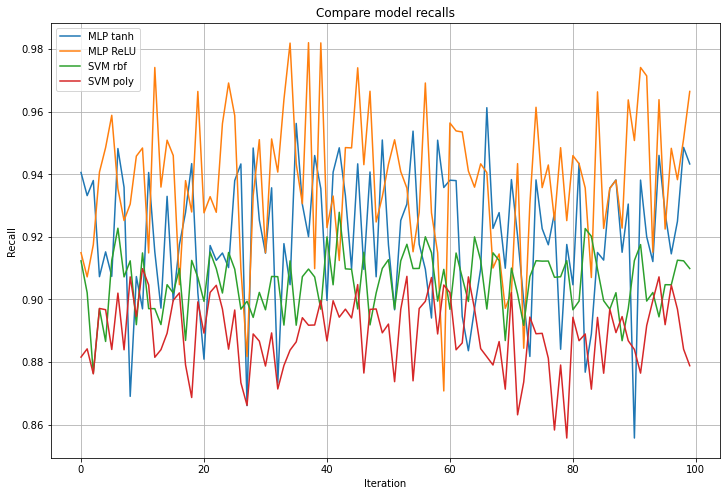

In [11]:
from matplotlib import pyplot as plt 
fig = plt.figure(figsize = (12, 8))

## Visualization of recall metrics of each model
plt.plot(all_average_recalls)
plt.title('Compare model recalls')
plt.ylabel('Recall')
plt.xlabel('Iteration')
plt.legend(['MLP tanh', 'MLP ReLU', 'SVM rbf', 'SVM poly'], loc = 'upper left')
plt.grid()
plt.show()

In [12]:
## Display the average recalls of all 4 models
print(np.mean(all_average_recalls, axis = 0))

[0.92002298 0.93811355 0.90544156 0.88914985]


In [13]:
## The 2nd MLP would be chosen, relu activation function for the hidden layer, because it has higher average recall score
## Between 2 SVM models, I would use the 1st one, rbf kernel, because it has higher average recall score

In [17]:
## 2.g
## Define input and target variables
train_input = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
train_target = telecom_train['Churn']
test_input = telecom_test[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
test_target = telecom_test['Churn']

## Scale input variables to range 0-1
train_input = scaler.fit_transform(train_input)
test_input = scaler.fit_transform(test_input)

## Display recall metrics
print('Recall of 2nd MLP: ', get_mlp2_recall(train_input, test_input, train_target, test_target))
print('Recall of 1st MLP: ', get_svm1_recall(train_input, test_input, train_target, test_target))

Recall of 2nd MLP:  0.9578947368421052
Recall of 1st MLP:  0.9263157894736842


In [15]:
## The MLP would be used because it has higher recall score